In [3]:
# import all libraries

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 120)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../data/train')
valid_files, valid_targets = load_dataset('../data/validation')
test_files, test_targets = load_dataset('../data/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../data/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 120 total dog categories.
There are 20580 total dog images.

There are 14531 training dog images.
There are 4232 validation dog images.
There are 1817 test dog images.


In [96]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential

pretrained_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in pretrained_model.layers:
    layer.trainable = False
    
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(120, activation='softmax')(x)

model = Model(inputs = pretrained_model.input, outputs=predictions) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [99]:
# training image augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
from keras.callbacks import History 
from keras.applications import vgg16

batch_size = 16

# this is the augmentation configuration I will use for training
train_datagen = ImageDataGenerator(rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=vgg16.preprocess_input)

# This is the augmentation configuration I will use for testing/validation... just a rescale
test_datagen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

# This is the generator which will read pictures found in my training subset
train_generator = train_datagen.flow_from_directory('../data/train/',
                                                    target_size = (224, 224),
                                                    batch_size = batch_size,
                                                    shuffle=False,
                                                    class_mode = 'categorical',
                                                    seed=42)

# This is the generator for validation data
validation_generator = test_datagen.flow_from_directory('../data/validation/',
                                                        target_size = (224, 224),
                                                        batch_size = batch_size,
                                                        shuffle=False,
                                                        class_mode = 'categorical')

Found 14531 images belonging to 120 classes.
Found 4232 images belonging to 120 classes.


In [73]:
test_generator = test_datagen.flow_from_directory('../data/test/',
                                                        target_size = (224, 224),
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical')

Found 1817 images belonging to 120 classes.


In [100]:
from keras.callbacks import ModelCheckpoint, History

history = History()
checkpoint_augmentation = '../data/checkpoint_augmentation'
model_checkpoint_augmentation = ModelCheckpoint(filepath=checkpoint_augmentation,
                                                verbose=1,
                                                save_best_only=True)

In [ ]:
%%time
model.fit_generator(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    callbacks = [model_checkpoint_augmentation, history],
                    verbose=2)

Epoch 1/10
 - 3929s - loss: 5.3434 - accuracy: 0.0507 - val_loss: 2.9550 - val_accuracy: 0.1640

Epoch 00001: val_loss improved from inf to 2.95499, saving model to ../data/checkpoint_augmentation
Epoch 2/10
 - 3878s - loss: 3.9399 - accuracy: 0.1358 - val_loss: 1.3897 - val_accuracy: 0.2800

Epoch 00002: val_loss improved from 2.95499 to 1.38965, saving model to ../data/checkpoint_augmentation
Epoch 3/10
 - 3866s - loss: 3.3833 - accuracy: 0.1963 - val_loss: 0.4902 - val_accuracy: 0.3774

Epoch 00003: val_loss improved from 1.38965 to 0.49017, saving model to ../data/checkpoint_augmentation
Epoch 4/10
 - 3859s - loss: 3.0975 - accuracy: 0.2363 - val_loss: 0.8420 - val_accuracy: 0.4499

Epoch 00004: val_loss did not improve from 0.49017
Epoch 5/10
 - 3859s - loss: 2.8826 - accuracy: 0.2657 - val_loss: 0.5144 - val_accuracy: 0.4898

Epoch 00005: val_loss did not improve from 0.49017
Epoch 6/10


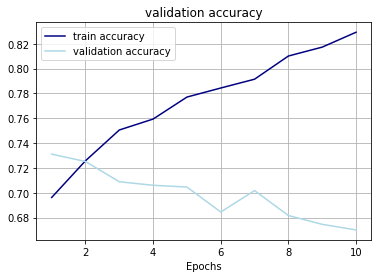

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

t = np.linspace(1, len(acc), len(acc)).flatten()
plt.plot(t, acc, 'navy', label='train accuracy')
plt.plot(t, val_acc, 'lightblue', label='validation accuracy')

plt.grid(True)
plt.xlabel('Epochs')
plt.title('validation accuracy')
plt.legend(loc=2)
plt.show();

In [75]:
vgg16_test_accuracy = model.evaluate_generator(test_generator, steps= len(test_generator.classes) // 16)[1]

In [78]:
model_stats = {
    'models': [],
    'accuracy': [],
    'test_accuracy': [],
    'epoch_training_time': [],
    'inference_time_10000pic': []
}

In [81]:
model_stats['models'].append('VGG16')

#Accuracy & validation accuracy
acc = history.history['accuracy'][-1]
model_stats['accuracy'].append(acc * 100)
model_stats['test_accuracy'].append(vgg16_test_accuracy * 100)


#Print results
print('Accuracy: %0.1f%% / Test accuracy: %0.1f%%' %(acc*100, vgg16_test_accuracy*100))


Accuracy: 82.9% / Test accuracy: 67.7%


NameError: name 'stats' is not defined

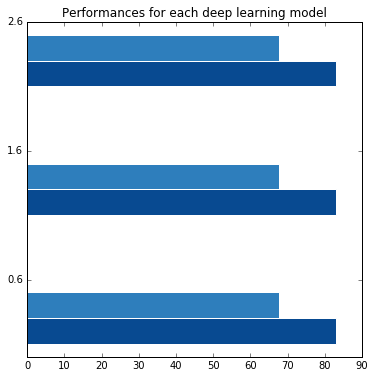

In [89]:

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
mpl.style.use('classic')
%matplotlib inline

accs = {k: v for k, v in model_stats.items()}


blues_cm = cm.Blues
width = 0.2
ind = np.arange(3)

fig, ax = plt.subplots(figsize=(6,6))

ax.barh(ind + width, accs['accuracy'], width, color=blues_cm(0.9), label="accuracy", edgecolor='white')
ax.barh(ind + 2 * width, accs['test_accuracy'], width, color=blues_cm(0.7),  label="test accuracy", edgecolor='white')


ax.set_title('Performances for each deep learning model')
ax.set_yticks(ind + width * 3)
ax.set_yticklabels(stats['models'])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Metrics', loc='lower right')

TypeError: Image data cannot be converted to float

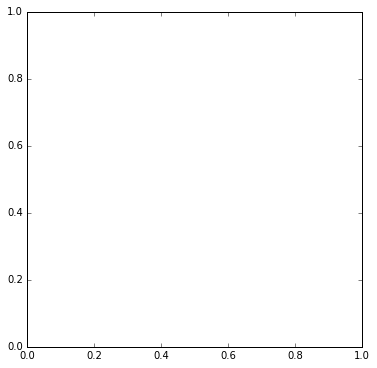

In [94]:
cmap=plt.cm.Blues

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('confusion matrix')
plt.colorbar(fraction=0.046, pad=0.04)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=rotation_xticks)
plt.yticks(tick_marks, classes)

if plot_values:
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        val = format(cm[i, j], fmt)
        val = int(float(val)) if (float(val) >= 1.) else val
        if float(val):
            plt.text(j, i, val,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [11]:
from keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def final_predict(img_path, topk = 3):
    
    # obtain predicted vector
    
    predicted_vector = model.predict(preprocess_input(path_to_tensor(img_path)))
    
    # return dog breed that is predicted by the model
    # print(dog_names[np.argmax(predicted_vector)])
    results = sorted(enumerate(predicted_vector[0]), reverse=True, key=lambda x:x[1])
    classes_ind = [x[0] for x in results]
    classes = [dog_names[x] for x in classes_ind][:topk]
    probs = [x[1] for x in results][:topk]
    
    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    
    img = mpimg.imread(img_path)
    ax1.imshow(img)
    
    ind = np.arange(len(classes))
    ax2.bar(ind, probs, align='center', alpha = .75)
    ax2.set_xticks(ind)
    ax2.set_xticklabels(classes, rotation=90)

In [12]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

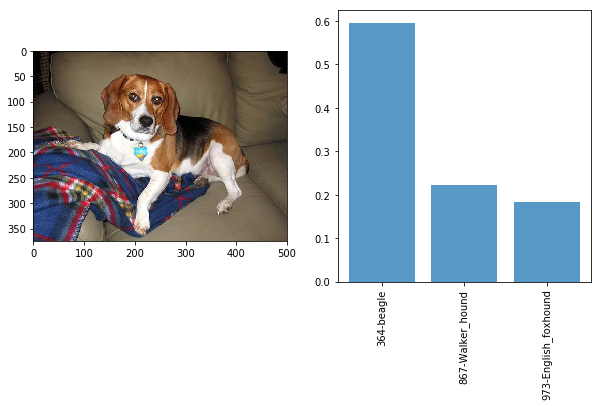

In [84]:
final_predict('../data/validation/n02088364-beagle/5.jpg')